Title

Description

Importing packages.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Importing data into pandas DataFrame.

In [2]:
from sklearn.preprocessing import MinMaxScaler
df = pd.read_csv(r"fullDataFinal.csv", index_col=0)
df.columns = df.columns.str.strip()
df.sample(5)

,fire_size_class,latitude,longitude,discovery_month,weekday,Vegetation,remoteness,elevation,Temp,Wind,Humidity,Precipitation
15946,B,32.770278,-86.742387,Mar,False,Shrubland,0.177984,185.0,-5.363234,4.511118,90.639094,0.000000
31139,B,37.352122,-92.425174,Dec,True,NaN,0.227173,377.0,26.244431,3.519702,73.528442,0.000000
14531,B,31.668321,-90.763406,Oct,False,Shrubland,0.215482,145.0,22.165292,1.913154,66.364661,0.266667
28001,B,36.511944,-121.753056,Oct,False,NaN,0.514087,189.0,15.758033,2.210244,76.442574,0.000000
32788,B,43.052747,-77.814553,Apr,True,Grassland,0.093136,175.0,1.647412,4.464063,74.371568,69.933333


Separate target variable (fire_size_class) from predictor variables.

In [3]:
dfTarget = df["fire_size_class"]
dfPredictor = df[["latitude", "longitude", "discovery_month", "weekday", "Vegetation", "remoteness", "elevation", "Temp", "Wind", "Humidity", "Precipitation"]]

Before doing anything, let's check the distribution of our data by plotting a histogram

d:\pycharmprojects\thesis\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'remoteness'}>],
       [<AxesSubplot:title={'center':'elevation'}>,
        <AxesSubplot:title={'center':'Temp'}>,
        <AxesSubplot:title={'center':'Wind'}>],
       [<AxesSubplot:title={'center':'Humidity'}>,
        <AxesSubplot:title={'center':'Precipitation'}>, <AxesSubplot:>]],
      dtype=object)

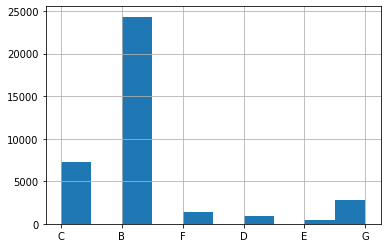

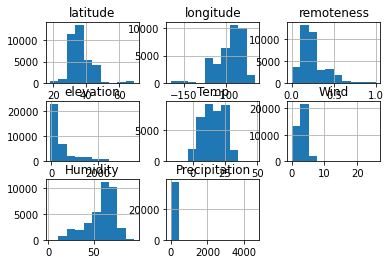

In [4]:
dfTarget.hist()
dfPredictor.hist()

Changing categorical variables into one-hot encoded ones.

In [5]:
# First let's do fire_size_class
dfTarget = pd.concat([dfTarget, pd.get_dummies(dfTarget)], axis=1)  # use get_dummies and concatenate the result to dfTarget
dfTarget.drop(["fire_size_class"], axis=1, inplace=True)  # and remove the old column
dfTarget.sample(5)

,B,C,D,E,F,G
13816,0,1,0,0,0,0
35859,0,0,0,0,1,0
22859,1,0,0,0,0,0
13760,1,0,0,0,0,0
28489,1,0,0,0,0,0


In [6]:
# Now Vegetation
dfPredictor = pd.concat([dfPredictor, pd.get_dummies(dfPredictor["Vegetation"], prefix="Veg", prefix_sep=" ")], axis=1)
dfPredictor.drop(["Vegetation"], axis=1, inplace=True)

# And discovery_month
dfPredictor = pd.concat([dfPredictor, pd.get_dummies(dfPredictor["discovery_month"])], axis=1)
dfPredictor.drop(["discovery_month"], axis=1, inplace=True)

# And weekday
dfPredictor = pd.concat([dfPredictor, pd.get_dummies(dfPredictor["weekday"])], axis=1)
dfPredictor.drop(["weekday"], axis=1, inplace=True)
dfPredictor.rename(columns={False:"is_weekend", True:"is_weekday"}, inplace=True)
dfPredictor.sample(5)

,latitude,longitude,remoteness,elevation,Temp,Wind,Humidity,Precipitation,Veg Broadleaf Forest,Veg Desert,...,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,is_weekend,is_weekday
9974,32.560704,-102.621231,0.326355,977.0,17.205043,4.754336,31.537839,0.0,0,0,...,0,0,0,0,0,0,0,0,0,1
18932,35.173300,-87.838300,0.186347,264.0,14.466626,2.191625,66.138267,61.9,0,0,...,0,0,0,0,0,1,0,0,0,1
25909,43.716667,-70.600000,0.030720,89.0,8.061461,3.093580,60.141530,0.0,0,0,...,0,0,0,0,1,0,0,0,0,1
6773,18.008820,-66.739410,0.017926,50.0,25.415864,4.557511,71.558232,0.0,0,0,...,0,0,0,0,0,0,0,0,0,1
15866,39.864440,-78.500280,0.100413,451.0,9.746936,4.244891,67.710424,40.3,0,0,...,0,0,0,0,0,0,1,0,1,0


Scaling numerical data to 0-1 range.

In [7]:
from sklearn.preprocessing import MinMaxScaler

dfPredictorScaled = pd.DataFrame(MinMaxScaler().fit_transform(dfPredictor[["latitude", "longitude", "remoteness", "elevation", "Temp", "Wind", "Humidity", "Precipitation"]]), columns=["latitude", "longitude", "remoteness", "elevation", "Temp", "Wind", "Humidity", "Precipitation"])
# dfPredictorScaled.sample(5)

dfPredictor = dfPredictor.assign(**dfPredictorScaled.to_dict(orient="series"))  # replace the columns of the old df with the ones from the new one
dfPredictor.sample(5)

,latitude,longitude,remoteness,elevation,Temp,Wind,Humidity,Precipitation,Veg Broadleaf Forest,Veg Desert,...,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,is_weekend,is_weekday
12487,0.418388,0.568037,0.379302,0.568020,0.683444,0.160645,0.219659,0.000000,0,0,...,0,1,0,0,0,0,0,0,1,0
29630,0.281523,0.643557,0.310542,0.194185,0.385643,0.209722,0.327565,0.000000,0,0,...,0,0,0,0,0,0,0,0,1,0
26172,0.460012,0.422995,0.523959,0.467636,0.656020,0.089544,0.409438,0.000609,0,0,...,0,1,0,0,0,0,0,0,0,1
36220,0.388500,0.597909,0.231454,0.751783,0.486761,0.174028,0.373066,0.000000,0,0,...,0,0,1,0,0,0,0,0,1,0
7467,0.277559,0.673984,0.281868,0.119035,0.473614,0.103910,0.575730,0.000000,0,0,...,0,0,0,0,0,1,0,0,0,1


Make a correlation matrix

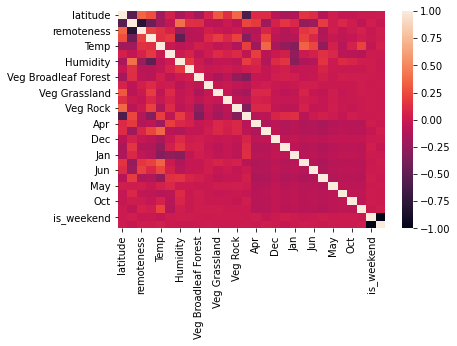

In [8]:
import seaborn as sn

corrMatrix = dfPredictor.corr()
sn.heatmap(corrMatrix)
plt.show()

Make a histogram distribution thing

Train-test split

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dfPredictor, dfTarget, test_size=0.1, random_state=42)

Training models, each in a cell (?)

* Dummy classifier
* K-Nearest Neighbour (KNN)
* Naïve Bayes (NB)
* Support Vector Machine (SVM)
* Decision Tree (DT)
* Random Forest (RF)
* Gradient Boosted Trees (GBT)
* Multi-Layered Perceptron (MLP)
* Artificial Neural Network (ANN)

Evaluation with confusion matrix, F1 score, etc

Dummy classifier

KNN

Trained in in 164.1297 seconds


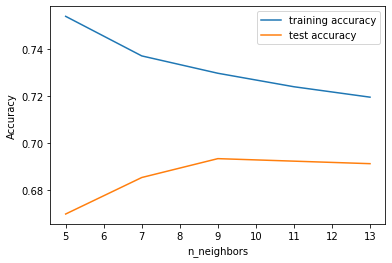

In [33]:
from sklearn.neighbors import KNeighborsClassifier
import time  # optional for timing the code

training_accuracy = []
test_accuracy = []
nNeighbors = range(5, 15, 2)

tic = time.perf_counter()  # timing start
for nNeighbor in nNeighbors:
    # build the model
    clf = KNeighborsClassifier(n_neighbors=nNeighbor, n_jobs=-1)
    clf.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))
toc = time.perf_counter()  # timing end
print(f"Trained in in {toc - tic:0.4f} seconds")  # print the time elapsed

plt.plot(nNeighbors, training_accuracy, label="training accuracy")
plt.plot(nNeighbors, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

9 seems to be the best on our test set. Let's train that model and save it.

In [34]:
clf = KNeighborsClassifier(n_neighbors=9, n_jobs=-1)
clf.fit(X_train, y_train)

training_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)
print(f"Number of neighbors: 9")
print("\nTraining accuracy: {training_accuracy}")  # 0.7298490543523656
print("\nTest accuracy: {test_accuracy}")  # 0.6934228187919463

Number of neighbors: 9 
Training accuracy: 0.7298490543523656 
Test accuracy: 0.6934228187919463


Naive Bayes

In [15]:
from sklearn.multioutput import MultiOutputClassifier  # (https://sklearn.org/modules/multiclass.html#multioutput-classification)

# train a Bernoulli Naive Bayes
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB(binarize=0.0)
multi_bnb = MultiOutputClassifier(bnb, n_jobs=-1)
multi_bnb.fit(X_train,y_train)
print(f"BernoulliNB train score: {multi_bnb.score(X_train, y_train)}")  # 0.593162699122964
print(f"BernoulliNB test score: {multi_bnb.score(X_test, y_test)}")  # 0.5884563758389262
print("\n")

# train a Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
multi_gnb = MultiOutputClassifier(gnb, n_jobs=-1)
multi_gnb.fit(X_train, y_train)
print(f"GaussianNB train score: {multi_gnb.score(X_train, y_train)}")  # 0.21296462024938845
print(f"GaussianNB test score: {multi_gnb.score(X_test, y_test)}")  # 0.21986577181208053
print("\n")

# train a Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
multi_mnb = MultiOutputClassifier(mnb, n_jobs=-1)
multi_mnb.fit(X_train,y_train)
print(f"MultinomialNB train score: {multi_mnb.score(X_train, y_train)}")  # 0.6040809020941471
print(f"MultinomialNB test score: {multi_mnb.score(X_test, y_test)}")  # 0.5978523489932885
print("\n")


BernoulliNB train score: 0.593162699122964
BernoulliNB test score: 0.5884563758389262


GaussianNB train score: 0.21296462024938845
GaussianNB test score: 0.21986577181208053


MultinomialNB train score: 0.6040809020941471
MultinomialNB test score: 0.5978523489932885




Support Vector Machine

Trained in in 963.3759 seconds


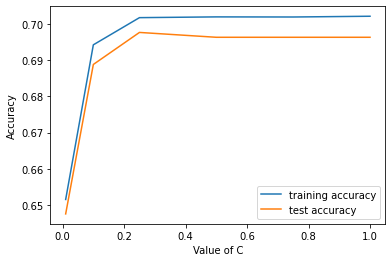

In [20]:
import time  # optional for timing the code
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier  # (https://sklearn.org/modules/multiclass.html#multioutput-classification)

training_accuracy = []
test_accuracy = []
C = [0.01, 0.1, 0.25, 0.5, 0.75, 1]

tic = time.perf_counter()  # timing start
for c in C:
    svm = SVC(C = c)
    multi_svm = MultiOutputClassifier(svm, n_jobs=-1)
    multi_svm.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(multi_svm.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(multi_svm.score(X_test, y_test))
toc = time.perf_counter()  # timing end
print(f"Trained in in {toc - tic:0.4f} seconds")  # print the time elapsed

plt.plot(C, training_accuracy, label="training accuracy")
plt.plot(C, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Value of C")
plt.legend()

Best seems to be with C = 0.25

Now lets train the final SVM

In [21]:
svm = SVC(C = 0.25)
multi_svm = MultiOutputClassifier(svm, n_jobs=-1)
multi_svm.fit(X_train, y_train)

print(f"Kernel SVM train score: {multi_svm.score(X_train, y_train)}")  # 0.7018077680329335
print(f"Kernel SVM test score: {multi_svm.score(X_test, y_test)}")  # 0.6977181208053691
print("\n")

MultinomialNB train score: 0.7018077680329335
MultinomialNB test score: 0.6977181208053691




Decision Tree

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 20, 40]}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, )
grid_search.fit(X_train, y_train)
scores = grid_search.cv_results_['mean_test_score']
print(scores)

print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

[0.51807742 0.70696852 0.71884132 0.69375329 0.72057161 0.71335242
 0.70989217 0.70634242 0.69825763 0.69014371 0.68277573 0.67782339
 0.66938098 0.66171467 0.63182408 0.60235061]
Test set score: 0.71


Best max_depth is 5 -->  0.72060144

In [24]:
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)

print(f"Decision Tree train score: {dt.score(X_train, y_train)}")  # 0.7240618101545254
print(f"Decision Tree test score: {dt.score(X_test, y_test)}")  # 0.7103355704697987
print("\n")

Decision Tree train score: 0.7240618101545254
Decision Tree test score: 0.7103355704697987




Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth':[2,4,8,10,11,12,13,14,15,16,20,30,40]}

grid_search = GridSearchCV(RandomForestClassifier(n_jobs=-1),param_grid, cv=5)
grid_search.fit(X_train, y_train)
scores = grid_search.cv_results_['mean_test_score']
print(scores)

print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

[0.69458851 0.69515544 0.69610995 0.69596085 0.69554323 0.69393231]
Test set score: 0.69


Best seems to be with max_depth=12

In [30]:
rf = RandomForestClassifier(max_depth=12, n_jobs=-1)
rf.fit(X_train, y_train)

print(f"Random Forest train score: {rf.score(X_train, y_train)}")  # 0.7210786945886284
print(f"Random Forest test score: {rf.score(X_test, y_test)}")  # 0.6877852348993289
print("\n")


Random Forest train score: 0.7210786945886284
Random Forest test score: 0.6877852348993289


